# Instructions for building a mosaic for MOM6/Ice-Shelf coupling to a cubed sphere ATM model

#### Pre-existing Directories

* `mosaic` :original mosaic files<br>
* `mosaic_mod` :Ice sheet exchange files<br>

#### GFDL HPC module environment:

* `python/3.9 (or higher)`
* `fre/bronx-21 (or higher)`

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import os

In [2]:
ds_atm=[]
for i in np.arange(1,7):
    ds_atm.append(xr.open_dataset('mosaic/land_mask_tile'+str(i)+'.nc'))
ds_ocn=xr.open_dataset('mosaic/ocean_mask.nc')

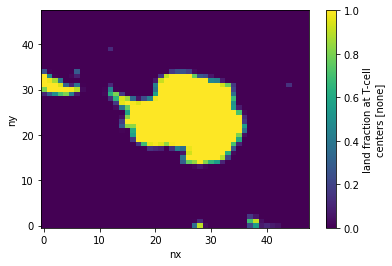

In [3]:
ds_atm[5]['mask'].plot()

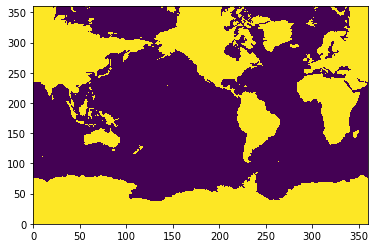

In [4]:
ocn_mask=ds_ocn['mask'].load().data
ocn_mask[np.abs(ocn_mask-1.0)<1.e-9]=1.0
ocn_mask=1.0-ocn_mask
plt.pcolormesh(ocn_mask)

In [5]:
def ice9it(i,j,depth):
  # Iterative implementation of "ice 9"
  wetMask = 0*depth
  (nj,ni) = wetMask.shape
  stack = set()
  stack.add( (j,i) )
  while stack:
    (j,i) = stack.pop()
    #print(i,j,wetMask[j,i],depth[j,i])
    if wetMask[j,i] or depth[j,i] == 0: continue
    wetMask[j,i] = 1
    if i>0: stack.add( (j,i-1) )
    else: stack.add( (j,ni-1) )
    if i<ni-1: stack.add( (j,i+1) )
    else: stack.add( (0,j) )
    if j>0: stack.add( (j-1,i) )
    if j<nj-1: stack.add( (j+1,i) )
    else: stack.add( (j,ni-1-i) )
  return wetMask


#### Create a mask for Antarctica

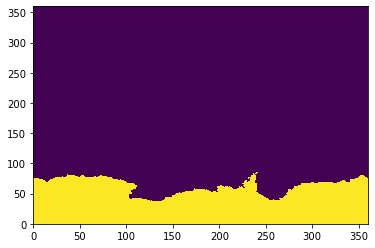

In [20]:
ant_mask = ice9it(150,0,ocn_mask)
plt.pcolormesh(ant_mask)

#### Create a mask for Greenland

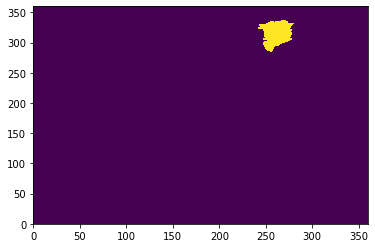

In [21]:
gr_mask = ice9it(260,300,ocn_mask)
plt.pcolormesh(gr_mask)

#### Combined Antarctica and Greenland mask

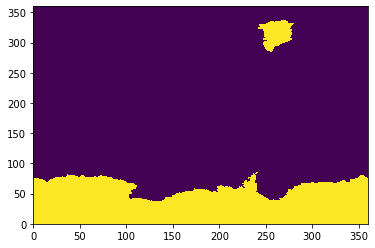

In [22]:
IS_mask=ant_mask+gr_mask
plt.pcolormesh(IS_mask)

#### Create a _bathymetry_ field using the ice sheet mask

In [25]:
f_topo=nc.Dataset('mosaic_mod/topog.nc','a')

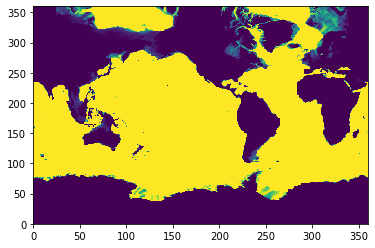

In [26]:
depth=f_topo.variables['depth'][:]
plt.pcolormesh(depth,vmin=5,vmax=500)

In [27]:
depth_mod=IS_mask*10.
f_topo.variables['depth'][:]=depth_mod
f_topo.sync()
f_topo.close()

In [28]:
ds_ocn_mod=nc.Dataset('mosaic_mod/ocean_hgrid.nc','a')
y=ds_ocn_mod.variables['y'][:]
y[0,:]=-90.
ds_ocn_mod.variables['y'][:]=y
ds_ocn_mod.sync()
ds_ocn_mod.close()

In [29]:
os.system("cd mosaic_mod;make_coupler_mosaic  --atmos_mosaic C48_mosaic.nc --ocean_mosaic ocean_mosaic.nc --mosaic_name mosaic --ocean_topog topog.nc --area_ratio_thresh 1.e-9")


make_coupler_mosaic: Calculating area_ocn based on lat-lon segments between adjacent grid points.
The maximum area mismatch is at tile=3, i=34, j=26, ratio=5.79666e-10, area_atm_grid=4.38597e+10, area_atm_xgrid=4.38597e+10

NOTE: axo_area_sum is 16184947396620.609375 and ocean fraction is 3.173118%
NOTE: axl_area_sum is 493879524513118.125000 and land  fraction is 96.826882%
NOTE: tiling error is 0.000000%


0

In [30]:
ds_atm_mod=[]
for i in np.arange(1,7):
    ds_atm_mod.append(xr.open_dataset('mosaic_mod/land_mask_tile'+str(i)+'.nc'))
ds_ocn_mod=xr.open_dataset('mosaic_mod/ocean_mask.nc')

#### Ice sheet exchange grid will be used to remap _ADOT_ mass fluxes calculated within the land model
#### and passed to SIS2/MOM6 via the FMScoupler 

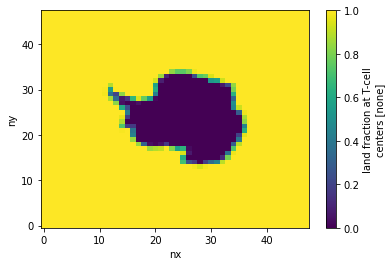

In [33]:
ds_atm_mod[5]['mask'].plot()

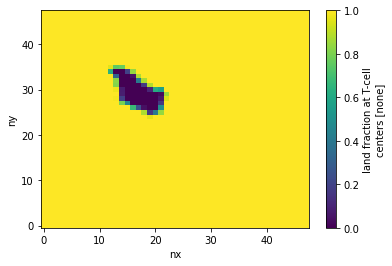

In [34]:
ds_atm_mod[2]['mask'].plot()